# Reversed condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d

Instead of looking at the condition it might be sensible to look at the reversed condition function
$$h(A):= \frac{\sigma_n}{\sigma_1} \geq \frac{\sigma_n}{\|A\|_F} := g(A)$$

### What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $C>\frac{\sigma_m}{\sigma_1} > 0$ for some $C>0$, but if it does not have full rank $\frac{\sigma_m}{\sigma_1} \approx 0$

If we assume that the relative condition can bound our problem, then we have:
\begin{equation}
    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | < (\frac{1}{\sigma_1}^2+\frac{\sigma_n}{\sigma_1^2}^2)\|E\|_F
\end{equation}
and
\begin{equation}
    | \frac{\sigma_n(A+E)}{\|A+E\|_F} - \frac{\sigma_n(A)}{\|A\|_F} | < (\frac{1}{\|A\|_F}+\frac{\sigma_n(A)}{\|A\|_F^2}) \ \|E\|_F
\end{equation}

In [2]:
"""
This calculates o_n/o_1
"""
def reverse_condition(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/sv[0]
    
"""
This calculates o_n/Frobenius_norm(A)
"""    
def reverse_condition_approx(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/np.linalg.norm(A)
    
def reverse_condition_bound(sv_max,sv_min,noisematrix):
    B=np.sqrt(1/sv_max+(sv_min/sv_max**2)**2)
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{sv_max:.3f} + {sv_min:.3f}/{sv_max**2:.3f})* {E:.3e} = {B:.3f}*{E:.3e}")
    return E*B

def reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A, noisematrix):
    B=1/frobenius_norm_A + sv_min/frobenius_norm_A**2
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{frobenius_norm_A:.3f} + {sv_min:.3f}/{frobenius_norm_A**2:.3f} )* {E:.3e}= {B:.3f}*{E:.3e}")
    
    return E*B

In [3]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5e6,50
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

0.5409139921983745
[[-1172326.10790127 -1513896.72689588 -2167305.93922467]
 [-2002957.51416881 -1270053.09659561 -3702913.1119874 ]
 [ -368909.99880443  -700072.00449987  -682012.30532994]
 [-1006300.70312814 -3246083.6833229  -1860370.99731576]
 [-1865500.77531073 -1004691.99055588 -3448793.71252533]
 [-1039487.92194883 -4855349.88300877 -1921724.96356428]
 [-1708255.79100738 -2767556.70319812 -3158091.33364199]
 [-2436451.84301897  -790147.73602921 -4504323.93718783]
 [-2135719.49210009 -2340776.88558557 -3948353.2001458 ]
 [-1228015.33752757  -430105.32158618 -2270259.88463839]]


In [4]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
frobenius_norm_A=np.linalg.norm(matrix)
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio smallest/biggest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {reverse_condition_bound(sv_max,sv_min,np.zeros(shape=matrix.shape))}")
print(f"Ratio smallest/Frobenius norm: {sv[-1]/frobenius_norm_A}")
print(f"Bound: {reverse_condition_bound_approx(sv_max,sv_min,np.linalg.norm(matrix),np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 2
Singular values : [1.21920345e+07 4.44585130e+06 3.75782841e-10]
Ratio smallest/biggest singular value: 3.082199630189399e-17
Bound: 0.0
Ratio smallest/Frobenius norm: 2.8956851163748253e-17
Bound: 0.0


In [5]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t diff \t \t bound \t \t diff_approx \t bound_approx")
ratios =[]
differences=[]
bounds =[]
ratios_approx =[]
differences_approx=[]
bounds_approx =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    # Compute h
    ratio = sv[-1]/sv[0]
    difference = np.abs(ratio-sv_min/sv_max)
    bound=reverse_condition_bound(sv_max,sv_min,noise)
    # Compute g
    ratio_approx= sv[-1]/np.linalg.norm(matrix_noise)    
    difference_approx = np.abs(ratio_approx-sv_min/frobenius_norm_A)
    bound_approx=reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A,noise)
    
    ratios.append(ratio)
    differences.append(difference)
    bounds.append(bound)
    
    ratios_approx.append(ratio_approx)
    differences_approx.append(difference_approx)
    bounds_approx.append(bound_approx)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {difference:3.3e}  \t {bound:3.3e}\t{difference_approx:3.3e}  \t {bound_approx:3.3e}")

Noise level 	 matrix rank 	 diff 	 	 bound 	 	 diff_approx 	 bound_approx
 0	 	 2 	 	 0.000e+00  	 0.000e+00	0.000e+00  	 0.000e+00
 1e-10	 	 3 	 	 3.174e-11  	 3.287e-07	2.982e-11  	 8.843e-11
 1e-09	 	 3 	 	 5.034e-10  	 3.335e-06	4.730e-10  	 8.973e-10
 1e-08	 	 3 	 	 4.972e-09  	 3.928e-05	4.671e-09  	 1.057e-08
 1e-07	 	 3 	 	 2.808e-08  	 2.943e-04	2.638e-08  	 7.919e-08
 1e-06	 	 3 	 	 6.954e-07  	 3.986e-03	6.533e-07  	 1.073e-06
 1e-05	 	 3 	 	 5.447e-06  	 4.224e-02	5.117e-06  	 1.136e-05
 0.0001	 	 3 	 	 5.924e-05  	 3.024e-01	5.566e-05  	 8.138e-05
 0.001	 	 3 	 	 3.899e-04  	 3.141e+00	3.663e-04  	 8.450e-04
 0.01	 	 3 	 	 4.570e-03  	 4.401e+01	4.294e-03  	 1.184e-02
 0.1	 	 3 	 	 4.820e-02  	 3.691e+02	4.525e-02  	 9.932e-02


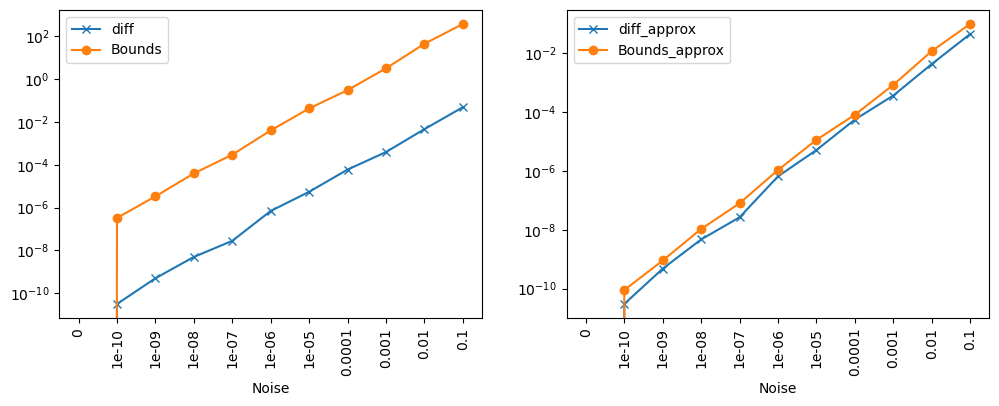

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(differences,marker='x',label="diff")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()
plt.subplot(1,2,2)
plt.plot(differences_approx,marker='x',label="diff_approx")
plt.plot(bounds_approx,marker='o',label="Bounds_approx")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()

### Threshold for $g(A) = \frac{\sigma_n}{\|A\|_F}$

#### Non uniqueness

We assume $\sigma_n=0$. Denote the singular value of $\tilde{A}=A+E$ by  $\tilde{\sigma}_n$ and $G=(u|u_x)$.
 $$\frac{\tilde{\sigma}_n}{\|\tilde{G}\|_F} \leq \frac{\sigma_n + \|G-\tilde{G}\|_F}{\|\tilde{G}\|_F} \leq  \frac{ \sqrt{C}}{\|\tilde{G}\|_F} = T_1$$
where $C = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is smaller than T_1, the function u should be nonunique. Note in the following we also use the threshold
$$T_2= \frac{\frac{\epsilon}{h} + h^{order} }{\|\tilde{G}\|_F}$$
where we ignore all constants and guess \epsilon, since we can not know these in practice.

In [7]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

In [8]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg



"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E


In [9]:
def calc_threshold_nonunique(frobenius_norm,eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    return (eps/h+h**order)/frobenius_norm

def calc_threshold2_nonunique(frobenius_norm,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return np.sqrt(E)/frobenius_norm

In [10]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)

dx=x[1]-x[0]

In [11]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
frobenius_norm_trueg = np.linalg.norm(true_g)
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/frobenius_norm_trueg:3.3e}")

M: 0.9999979518703823
Singular values of g: (36.25512335026134, 34.432049472218964)
sv_max/sv_min: 6.886e-01


True ratio: 1.053e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
	  	 2 	 	 6.886e-01 	 8.330e-06 	 6.942e-05
	  	 3 	 	 6.886e-01 	 1.700e-07 	 2.125e-06
	  	 4 	 	 6.886e-01 	 3.469e-09 	 5.782e-09
	  	 5 	 	 6.886e-01 	 7.080e-11 	 5.902e-10
	  	 6 	 	 6.886e-01 	 1.445e-12 	 5.360e-13
	  	 7 	 	 6.886e-01 	 2.971e-14 	 6.850e-13
	  	 8 	 	 6.886e-01 	 8.194e-16 	 2.271e-14
	  	 9 	 	 6.886e-01 	 2.299e-16 	 1.468e-12


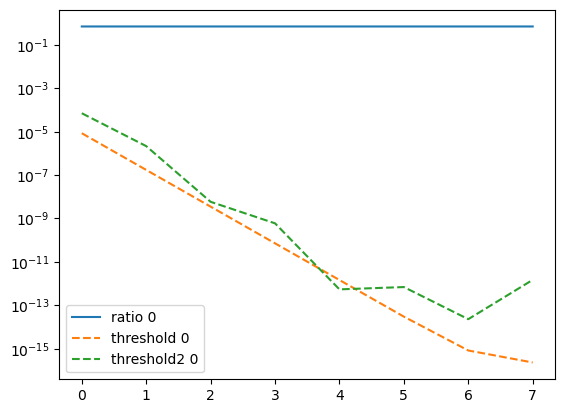

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
3.556796023109128e-09
	  	 2 	 	 6.886e-01 	 8.330e-06 	 6.943e-05
	  	 3 	 	 6.886e-01 	 1.702e-07 	 2.206e-06
	  	 4 	 	 6.886e-01 	 3.712e-09 	 2.400e-08
	  	 5 	 	 6.886e-01 	 3.137e-10 	 2.079e-07
	  	 6 	 	 6.886e-01 	 2.444e-10 	 2.227e-08
	  	 7 	 	 6.886e-01 	 2.430e-10 	 5.590e-07
	  	 8 	 	 6.886e-01 	 2.429e-10 	 2.531e-08
	  	 9 	 	 6.886e-01 	 2.429e-10 	 1.639e-06


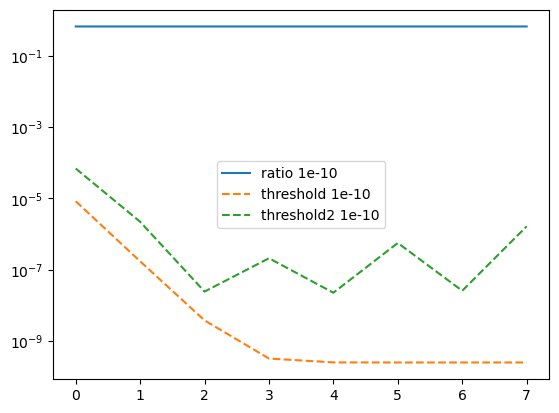

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
3.581920677680107e-08
	  	 2 	 	 6.886e-01 	 8.332e-06 	 6.954e-05
	  	 3 	 	 6.886e-01 	 1.724e-07 	 2.919e-06
	  	 4 	 	 6.886e-01 	 5.851e-09 	 1.844e-07
	  	 5 	 	 6.886e-01 	 2.452e-09 	 2.033e-06
	  	 6 	 	 6.886e-01 	 2.383e-09 	 2.183e-07
	  	 7 	 	 6.886e-01 	 2.381e-09 	 5.480e-06
	  	 8 	 	 6.886e-01 	 2.381e-09 	 2.481e-07
	  	 9 	 	 6.886e-01 	 2.381e-09 	 1.606e-05


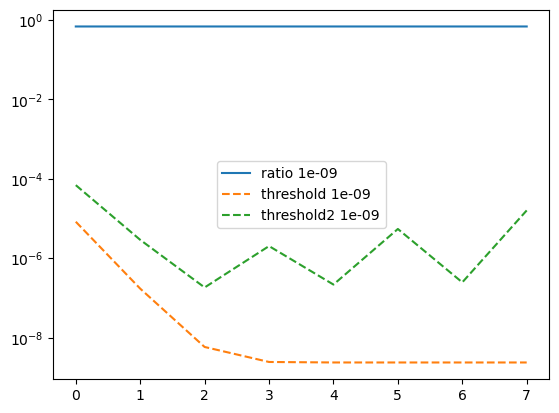

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
3.5670294062498594e-07
	  	 2 	 	 6.886e-01 	 8.357e-06 	 7.074e-05
	  	 3 	 	 6.886e-01 	 1.965e-07 	 1.097e-05
	  	 4 	 	 6.886e-01 	 3.000e-08 	 1.995e-06
	  	 5 	 	 6.886e-01 	 2.660e-08 	 2.264e-05
	  	 6 	 	 6.886e-01 	 2.653e-08 	 2.432e-06
	  	 7 	 	 6.886e-01 	 2.653e-08 	 6.104e-05
	  	 8 	 	 6.886e-01 	 2.653e-08 	 2.763e-06
	  	 9 	 	 6.886e-01 	 2.653e-08 	 1.789e-04


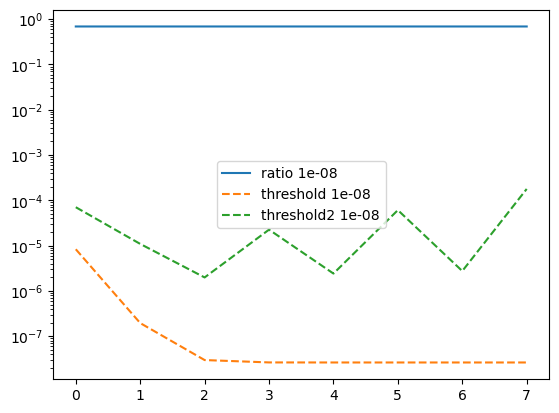

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
3.6951890946578158e-06
	  	 2 	 	 6.886e-01 	 8.580e-06 	 8.189e-05
	  	 3 	 	 6.886e-01 	 4.194e-07 	 8.527e-05
	  	 4 	 	 6.886e-01 	 2.529e-07 	 1.871e-05
	  	 5 	 	 6.886e-01 	 2.495e-07 	 2.128e-04
	  	 6 	 	 6.886e-01 	 2.494e-07 	 2.286e-05
	  	 7 	 	 6.886e-01 	 2.494e-07 	 5.739e-04
	  	 8 	 	 6.886e-01 	 2.494e-07 	 2.598e-05
	  	 9 	 	 6.886e-01 	 2.494e-07 	 1.682e-03


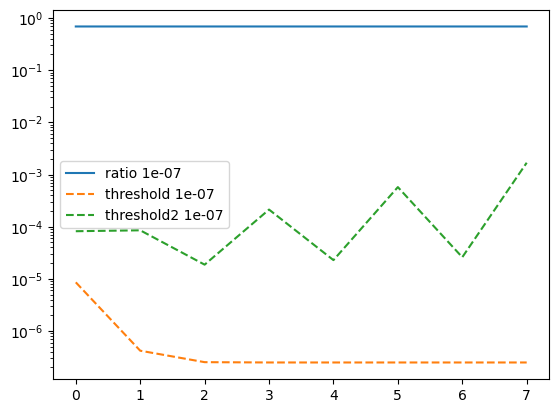

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
3.653272824065222e-05
	  	 2 	 	 6.886e-01 	 1.104e-05 	 2.048e-04
	  	 3 	 	 6.886e-01 	 2.878e-06 	 9.047e-04
	  	 4 	 	 6.886e-01 	 2.711e-06 	 2.031e-04
	  	 5 	 	 6.886e-01 	 2.708e-06 	 2.311e-03
	  	 6 	 	 6.886e-01 	 2.708e-06 	 2.482e-04
	  	 7 	 	 6.886e-01 	 2.708e-06 	 6.230e-03
	  	 8 	 	 6.886e-01 	 2.708e-06 	 2.821e-04
	  	 9 	 	 6.886e-01 	 2.708e-06 	 1.826e-02


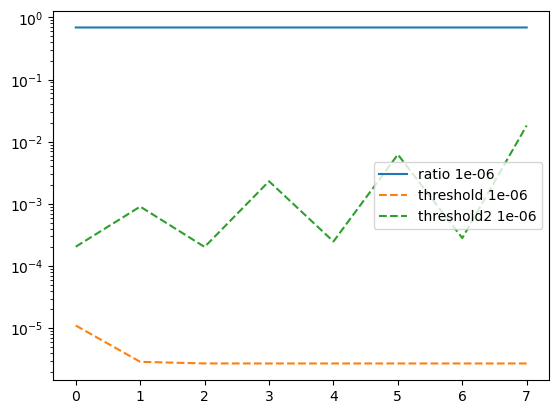

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.00036195108033249365
	  	 2 	 	 6.886e-01 	 3.323e-05 	 1.314e-03
	  	 3 	 	 6.886e-01 	 2.507e-05 	 8.302e-03
	  	 4 	 	 6.886e-01 	 2.490e-05 	 1.868e-03
	  	 5 	 	 6.886e-01 	 2.490e-05 	 2.125e-02
	  	 6 	 	 6.886e-01 	 2.490e-05 	 2.283e-03
	  	 7 	 	 6.886e-01 	 2.490e-05 	 5.729e-02
	  	 8 	 	 6.887e-01 	 2.490e-05 	 2.594e-03
	  	 9 	 	 6.887e-01 	 2.490e-05 	 1.679e-01


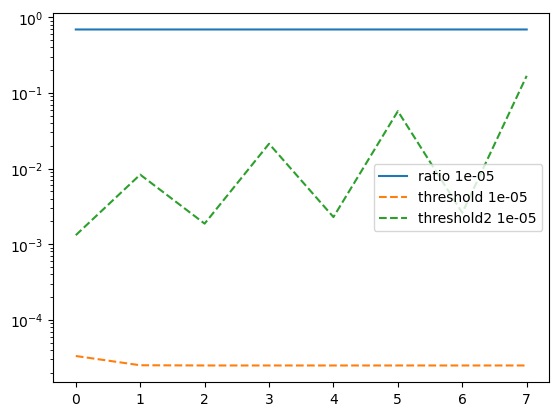

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.0036121689657825
	  	 2 	 	 6.886e-01 	 2.693e-04 	 1.312e-02
	  	 3 	 	 6.887e-01 	 2.611e-04 	 8.697e-02
	  	 4 	 	 6.887e-01 	 2.609e-04 	 1.957e-02
	  	 5 	 	 6.887e-01 	 2.609e-04 	 2.227e-01
	  	 6 	 	 6.887e-01 	 2.609e-04 	 2.392e-02
	  	 7 	 	 6.887e-01 	 2.609e-04 	 6.004e-01
	  	 8 	 	 6.888e-01 	 2.609e-04 	 2.718e-02
	  	 9 	 	 6.892e-01 	 2.608e-04 	 1.759e+00


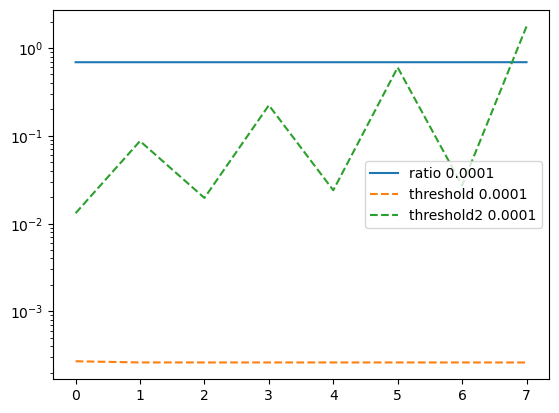

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.0353832830110195
	  	 2 	 	 6.891e-01 	 2.745e-03 	 1.369e-01
	  	 3 	 	 6.897e-01 	 2.735e-03 	 9.115e-01
	  	 4 	 	 6.899e-01 	 2.733e-03 	 2.050e-01
	  	 5 	 	 6.911e-01 	 2.729e-03 	 2.329e+00
	  	 6 	 	 6.930e-01 	 2.721e-03 	 2.494e-01
	  	 7 	 	 6.971e-01 	 2.700e-03 	 6.212e+00
	  	 8 	 	 6.957e-01 	 2.647e-03 	 2.758e-01
	  	 9 	 	 6.629e-01 	 2.514e-03 	 1.696e+01


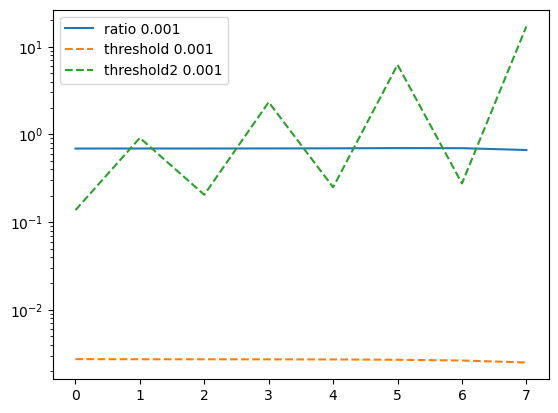

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.35407610271470297
	  	 2 	 	 6.940e-01 	 2.398e-02 	 1.199e+00
	  	 3 	 	 6.552e-01 	 2.259e-02 	 7.530e+00
	  	 4 	 	 6.512e-01 	 2.245e-02 	 1.684e+00
	  	 5 	 	 6.030e-01 	 2.078e-02 	 1.773e+01
	  	 6 	 	 5.431e-01 	 1.871e-02 	 1.715e+00
	  	 7 	 	 4.331e-01 	 1.492e-02 	 3.434e+01
	  	 8 	 	 3.063e-01 	 1.055e-02 	 1.099e+00
	  	 9 	 	 1.943e-01 	 6.696e-03 	 4.517e+01


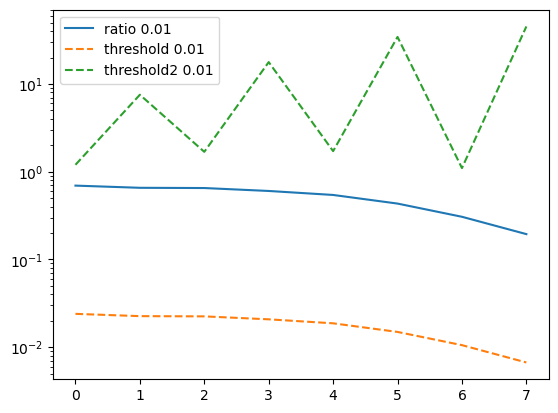

In [12]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise = np.linalg.norm(g_noise)
        ratio=sv[-1]/frobenius_norm_gnoise
        
        threshold = calc_threshold_nonunique(frobenius_norm_gnoise,eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2_nonunique(frobenius_norm_gnoise,eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
                                               
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try a threshold for unqiue values
We choose $C>0$ such that $\sigma_n \geq C$. Then
$$\frac{\tilde\sigma_n}{\|\tilde{G}\|} \geq \frac{\sigma_n -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\sqrt{E}}{\|\tilde{G}\|}$$
The ideal $C$ would be $C = \sigma_n$. However, in practice we do not know the true singular valuse. Thus, we can educately guess with:
$$C =\tilde\sigma_n-\sqrt{eps/h+h^{order}}$$
This approximates deviation we get from the derivative calculation.

In [125]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c(u,eps,h):
    #Calculate omin omax
    order=2
    ux= ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    omin = svd(g, compute_uv=False)[-1]
    #Calculate C  
    print(eps,h,order)
    E = (eps/h+h**order)
    print(omin,E)
    assert omin - np.sqrt(E) >0
    C = max(omin - np.sqrt(E) , 1e-14)
    return C

"""
This calculates the threshold with minimal knowlegdede
C: lower bound on >= C
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq(C,frobenius_norm,eps,h,order=2):
    E = (eps/h+h**order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq2(C,frobenius_norm,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T

In [126]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""

u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

In [127]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 0.099979594612992
Singular values of g: (7.703469744234607, 6.37624920307088)
sv_max/sv_min: 0.770


In [128]:
#Best choice C1 C2
C=sv_min
print(f"C: {C}")

C: 6.37624920307088


True ratio: 1.208e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
0.0 0.05050505050505061 2
6.375683068081233 0.0025507601265177125
C: 6.325178017576182, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


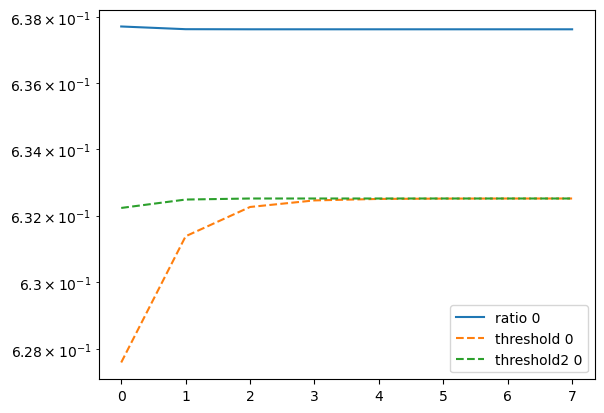

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.721213537490964e-10
2.6188551327521736e-11 0.05050505050505061 2
6.375683068107897 0.0025507606450510287
C: 6.325178012469366, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


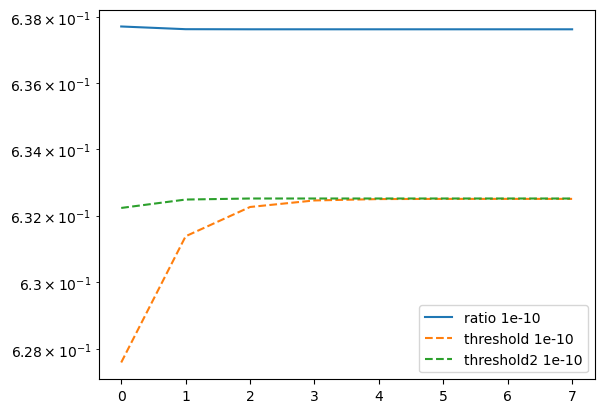

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.6717901174134954e-09
2.5214019760966266e-10 0.05050505050505061 2
6.375683068186533 0.0025507651188936254
C: 6.325177968256986, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


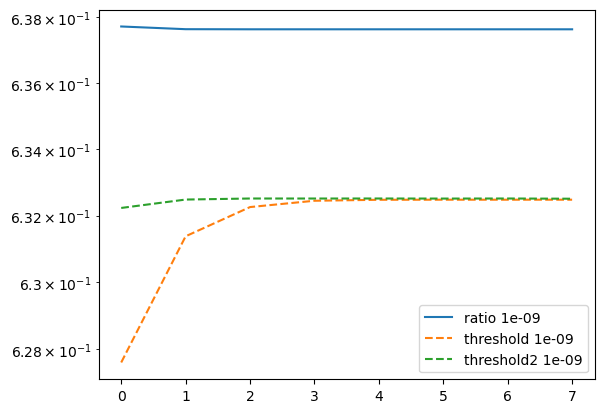

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.643378231387705e-08
2.713481800364903e-09 0.05050505050505061 2
6.375683069233536 0.0025508138534573598
C: 6.325177486834583, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.324e-01 	 	 6.324e-01


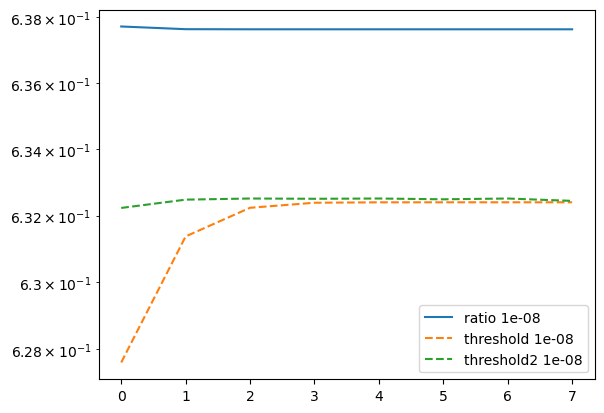

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.619317912705092e-07
2.7748442786579286e-08 0.05050505050505061 2
6.375683026809831 0.002551309545684887
C: 6.32517253734789, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.313e-01 	 	 6.324e-01
	  	 4 	 	 6.376e-01 	 	 6.321e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.322e-01 	 	 6.324e-01
	  	 6 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.322e-01 	 	 6.323e-01
	  	 8 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.322e-01 	 	 6.318e-01


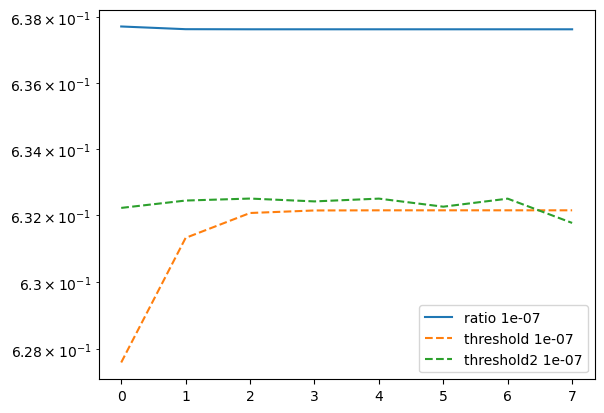

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
6.683632630649095e-06
2.453557582382526e-07 0.05050505050505061 2
6.37568306242655 0.00255561817053083
C: 6.3251299401636185, Check 
	  	 2 	 	 6.377e-01 	 	 6.275e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.309e-01 	 	 6.322e-01
	  	 4 	 	 6.376e-01 	 	 6.313e-01 	 	 6.324e-01
	  	 5 	 	 6.376e-01 	 	 6.314e-01 	 	 6.317e-01
	  	 6 	 	 6.376e-01 	 	 6.314e-01 	 	 6.324e-01
	  	 7 	 	 6.376e-01 	 	 6.314e-01 	 	 6.303e-01
	  	 8 	 	 6.376e-01 	 	 6.314e-01 	 	 6.324e-01
	  	 9 	 	 6.376e-01 	 	 6.314e-01 	 	 6.260e-01


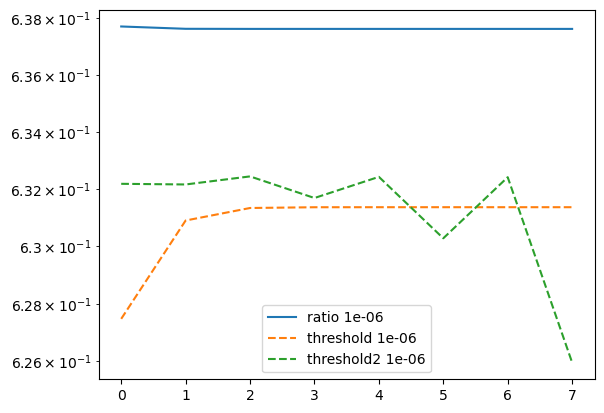

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
6.706647836589106e-05
2.2316899542518254e-06 0.05050505050505061 2
6.375686688698872 0.0025949475876118986
C: 6.324746060634311, Check 
	  	 2 	 	 6.377e-01 	 	 6.264e-01 	 	 6.317e-01
	  	 3 	 	 6.376e-01 	 	 6.287e-01 	 	 6.295e-01
	  	 4 	 	 6.376e-01 	 	 6.288e-01 	 	 6.318e-01
	  	 5 	 	 6.376e-01 	 	 6.288e-01 	 	 6.249e-01
	  	 6 	 	 6.376e-01 	 	 6.288e-01 	 	 6.317e-01
	  	 7 	 	 6.376e-01 	 	 6.288e-01 	 	 6.121e-01
	  	 8 	 	 6.376e-01 	 	 6.288e-01 	 	 6.316e-01
	  	 9 	 	 6.376e-01 	 	 6.288e-01 	 	 5.729e-01


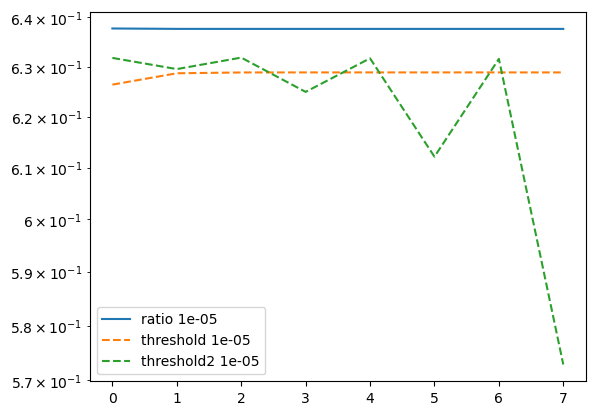

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.0006801005156080798
2.7613484932331386e-05 0.05050505050505061 2
6.375705449666972 0.003097507128177873
C: 6.320050197190877, Check 
	  	 2 	 	 6.377e-01 	 	 6.195e-01 	 	 6.263e-01
	  	 3 	 	 6.376e-01 	 	 6.203e-01 	 	 5.955e-01
	  	 4 	 	 6.376e-01 	 	 6.204e-01 	 	 6.238e-01
	  	 5 	 	 6.376e-01 	 	 6.204e-01 	 	 5.387e-01
	  	 6 	 	 6.376e-01 	 	 6.204e-01 	 	 6.220e-01
	  	 7 	 	 6.376e-01 	 	 6.204e-01 	 	 3.804e-01
	  	 8 	 	 6.376e-01 	 	 6.204e-01 	 	 6.206e-01
	  	 9 	 	 6.376e-01 	 	 6.204e-01 	 	 1.000e-13


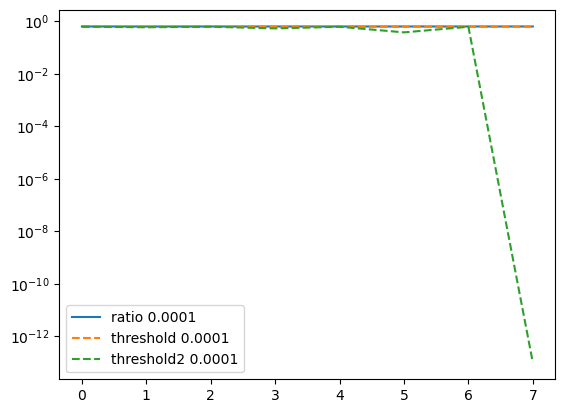

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.006678544896791372
0.00032608671965159153 0.05050505050505061 2
6.375924396544227 0.009007277175619211
C: 6.2810177204059325, Check 
	  	 2 	 	 6.377e-01 	 	 5.915e-01 	 	 5.632e-01
	  	 3 	 	 6.376e-01 	 	 5.916e-01 	 	 1.976e-01
	  	 4 	 	 6.376e-01 	 	 5.917e-01 	 	 5.312e-01
	  	 5 	 	 6.376e-01 	 	 5.916e-01 	 	 1.000e-13
	  	 6 	 	 6.376e-01 	 	 5.915e-01 	 	 5.095e-01
	  	 7 	 	 6.376e-01 	 	 5.913e-01 	 	 1.000e-13
	  	 8 	 	 6.375e-01 	 	 5.906e-01 	 	 4.926e-01
	  	 9 	 	 6.369e-01 	 	 5.887e-01 	 	 1.000e-13


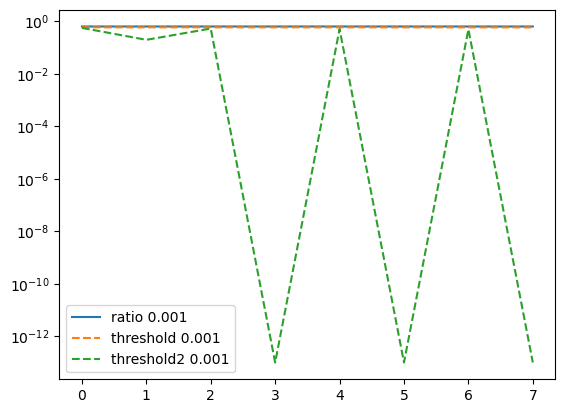

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.06840424272050973
0.002812748831557868 0.05050505050505061 2
6.395581716839997 0.05824318699136338
C: 6.154245463882917, Check 
	  	 2 	 	 6.359e-01 	 	 4.961e-01 	 	 5.771e-02
	  	 3 	 	 6.330e-01 	 	 4.915e-01 	 	 1.000e-13
	  	 4 	 	 6.329e-01 	 	 4.918e-01 	 	 1.000e-13
	  	 5 	 	 6.289e-01 	 	 4.863e-01 	 	 1.000e-13
	  	 6 	 	 6.235e-01 	 	 4.802e-01 	 	 1.000e-13
	  	 7 	 	 6.054e-01 	 	 4.619e-01 	 	 1.000e-13
	  	 8 	 	 5.580e-01 	 	 4.214e-01 	 	 1.000e-13
	  	 9 	 	 4.554e-01 	 	 3.411e-01 	 	 1.000e-13


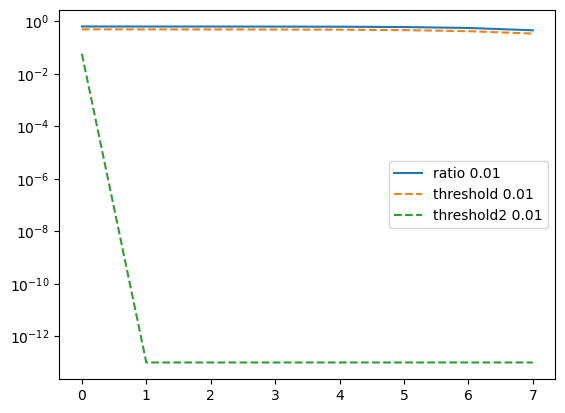

In [129]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise        
        threshold = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t \t {threshold:3.3e} \t \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

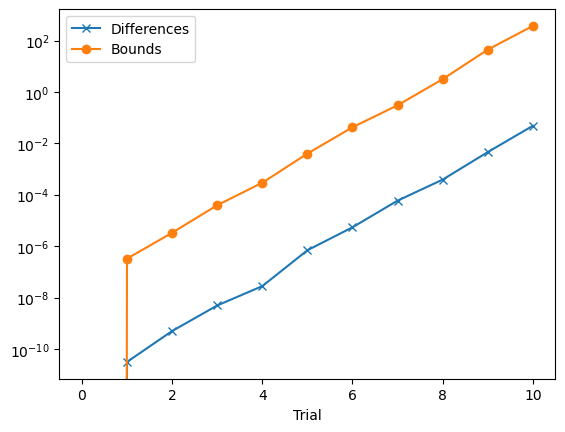

In [84]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

### Combine non uniqueness and uniqueness bound

In [130]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
b=np.random.randn()
C=1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 36.75428606069079
Singular values of g: (1278.2381779908912, 6.447166765342988e-14)
sv_max/sv_min: 1.000


True ratio: 1.983e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
C: 6.447166765342988e-14, Check 


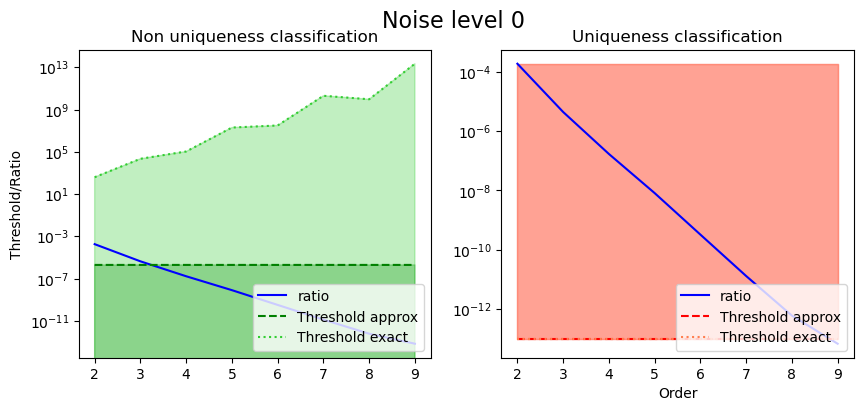

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
8.936897234873628e-08
C: 6.447166765342988e-14, Check 


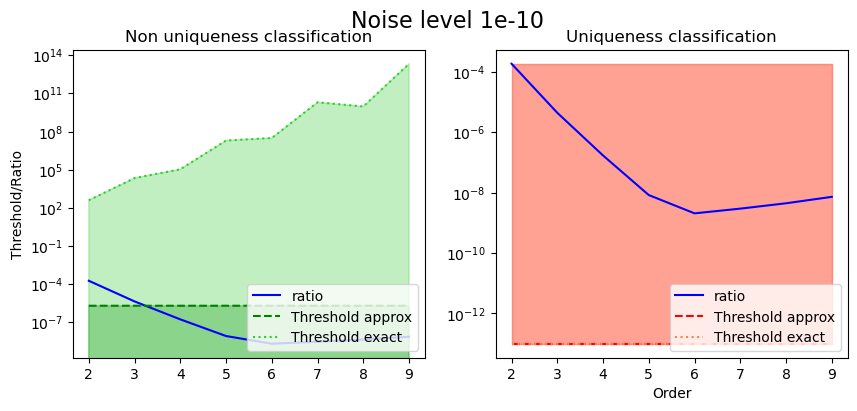

In [131]:
M=infinity_norm(uxxx)
number_noise=2 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C=sv_min
for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    #C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise   
        
        threshold_uniq = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_uniq = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
  
        threshold_nonunique = calc_threshold_nonunique(frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_nonunique = calc_threshold2_nonunique(frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='limegreen')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='limegreen', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()

In [124]:
threshold_uniq_list

[0, 0, 0, 0, 0, 0, 0, 0]